In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize GradCAM
        Args:
            model: Pre-trained model
            target_layer: Layer để tính GradCAM (vd: model.layer4)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        """Hook để lưu activation maps"""
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        """Hook để lưu gradients"""
        self.gradients = grad_output[0].detach()
    
    def compute_weights(self, class_idx):
        """
        Tính weights (alpha_i) theo công thức (1) của GradCAM paper
        alpha_i^c = (1/Z) * sum_{i,j} (dY^c / dA_ij^k)
        
        Args:
            class_idx: Index của predicted class
        Returns:
            weights: Tensor chứa weight của từng channel [n_channels]
        """
        # Gradients có shape [batch, channels, height, width]
        # Global Average Pooling của gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=False)  # [batch, channels]
        
        return weights.squeeze()  # [n_channels]
    
    def forward(self, x, class_idx=None):
        """
        Forward pass và tính GradCAM
        Args:
            x: Input image tensor [1, 3, H, W]
            class_idx: Target class index (None = predicted class)
        Returns:
            weights: Weight của từng channel
            cam: GradCAM heatmap
            pred_class: Predicted class
        """
        # Forward pass
        self.model.eval()
        logits = self.model(x)
        
        # Nếu không chỉ định class, dùng predicted class
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward từ pre-softmax score của class c
        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1
        logits.backward(gradient=one_hot, retain_graph=True)
        
        # Tính weights (alpha_i)
        weights = self.compute_weights(class_idx)
        
        # Tính GradCAM: L^c = ReLU(sum_i alpha_i * A_i)
        activations = self.activations.squeeze()  # [channels, h, w]
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)  # Normalize
        
        return weights, cam, class_idx



In [ ]:

def analyze_weight_distribution(weights, top_k=10):
    """
    Phân tích distribution của weights
    Args:
        weights: Tensor chứa weights của các channels
        top_k: Số lượng top channels để hiển thị
    """
    weights_np = weights.cpu().numpy()
    n_channels = len(weights_np)
    
    # Tạo figure với 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Histogram của weights
    axes[0].hist(weights_np, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Weight Value (α_i)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Channel Weights', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Statistics
    mean_w = weights_np.mean()
    std_w = weights_np.std()
    axes[0].axvline(mean_w, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_w:.4f}')
    axes[0].axvline(mean_w + std_w, color='orange', linestyle='--', linewidth=1.5, label=f'±1 Std: {std_w:.4f}')
    axes[0].axvline(mean_w - std_w, color='orange', linestyle='--', linewidth=1.5)
    axes[0].legend()
    
    # 2. Bar plot của top-k channels
    top_indices = np.argsort(weights_np)[-top_k:][::-1]
    top_weights = weights_np[top_indices]
    
    axes[1].bar(range(top_k), top_weights, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Rank', fontsize=12)
    axes[1].set_ylabel('Weight Value', fontsize=12)
    axes[1].set_title(f'Top-{top_k} Channel Weights', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(top_k))
    axes[1].set_xticklabels([f'Ch {idx}' for idx in top_indices], rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # 3. Cumulative distribution
    sorted_weights = np.sort(weights_np)[::-1]
    cumsum = np.cumsum(sorted_weights)
    cumsum_normalized = cumsum / cumsum[-1] * 100
    
    axes[2].plot(range(n_channels), cumsum_normalized, linewidth=2)
    axes[2].set_xlabel('Number of Channels', fontsize=12)
    axes[2].set_ylabel('Cumulative Weight (%)', fontsize=12)
    axes[2].set_title('Cumulative Weight Distribution', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
    axes[2].axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
    axes[2].legend()
    
    plt.tight_layout()
    # plt.savefig('weight_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # In thống kê
    print("\n" + "="*60)
    print("WEIGHT DISTRIBUTION ANALYSIS")
    print("="*60)
    print(f"Total channels: {n_channels}")
    print(f"Mean weight: {mean_w:.6f}")
    print(f"Std weight: {std_w:.6f}")
    print(f"Min weight: {weights_np.min():.6f}")
    print(f"Max weight: {weights_np.max():.6f}")
    print(f"Weight range: {weights_np.max() - weights_np.min():.6f}")
    
    # Phân tích concentration
    total_weight = np.sum(np.abs(weights_np))
    top_10_percent = int(n_channels * 0.1)
    top_10_weight = np.sum(np.abs(sorted_weights[:top_10_percent]))
    concentration_ratio = top_10_weight / total_weight * 100
    
    print(f"\nConcentration Analysis:")
    print(f"Top 10% channels ({top_10_percent} channels) contribute: {concentration_ratio:.2f}% of total weight")
    
    # Tìm số channels chiếm 50% và 80% weight
    idx_50 = np.where(cumsum_normalized >= 50)[0][0]
    idx_80 = np.where(cumsum_normalized >= 80)[0][0]
    print(f"Top {idx_50+1} channels contribute 50% of total weight")
    print(f"Top {idx_80+1} channels contribute 80% of total weight")
    
    # Uniformity test (so sánh với uniform distribution)
    uniform_mean = 1.0 / n_channels
    normalized_weights = np.abs(weights_np) / np.sum(np.abs(weights_np))
    kl_divergence = np.sum(normalized_weights * np.log((normalized_weights + 1e-10) / uniform_mean))
    print(f"\nKL Divergence from uniform: {kl_divergence:.6f}")
    if kl_divergence < 0.1:
        print("→ Distribution is nearly UNIFORM")
    elif kl_divergence < 1.0:
        print("→ Distribution is MODERATELY concentrated")
    else:
        print("→ Distribution is HIGHLY concentrated")
    
    print("\n" + "="*60)
    print(f"TOP-{top_k} CHANNELS WITH HIGHEST WEIGHTS")
    print("="*60)
    print(f"{'Rank':<6} {'Channel ID':<12} {'Weight':<15} {'% of Max':<12}")
    print("-"*60)
    
    for rank, (idx, weight) in enumerate(zip(top_indices, top_weights), 1):
        pct = weight / weights_np.max() * 100
        print(f"{rank:<6} {idx:<12} {weight:<15.6f} {pct:<12.2f}%")
    
    print("="*60)
    
    return top_indices, top_weights



In [15]:

def visualize_gradcam(original_img, cam, pred_class, class_name=None):
    """Visualize GradCAM heatmap"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # GradCAM heatmap
    cam_resized = F.interpolate(
        cam.unsqueeze(0).unsqueeze(0),
        size=original_img.size[::-1],
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().numpy()
    
    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(original_img)
    axes[2].imshow(cam_resized, cmap='jet', alpha=0.5)
    title = f'GradCAM Overlay\nClass: {pred_class}'
    if class_name:
        title += f' ({class_name})'
    axes[2].set_title(title, fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    # plt.savefig('gradcam_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()



In [16]:
# EXAMPLE USAGE
def get_target_layer(model):
    """
    Tự động chọn target layer phù hợp cho từng loại model
    """
    if hasattr(model, 'layer4'):  # ResNet, ResNeXt
        return model.layer4[-1]
    elif hasattr(model, 'features'):  # VGG, AlexNet, DenseNet
        # Tìm conv layer cuối cùng trong features
        for layer in reversed(model.features):
            if isinstance(layer, nn.Conv2d):
                return layer
        return model.features[-1]
    elif hasattr(model, 'conv_head'):  # EfficientNet
        return model.conv_head
    elif hasattr(model, 'stages'):  # ConvNeXt
        return model.stages[-1]
    else:
        raise ValueError(f"Không tìm thấy target layer phù hợp cho model {type(model).__name__}")

In [17]:
from torchvision import models
# Load pre-trained ResNet50
model = models.alexnet(pretrained=True)
model.eval();


/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [23]:
# Prepare image
img_path = 'bird.png'  # Thay đổi path
img = Image.open(img_path).convert('RGB')

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)



In [25]:
def analyze_layer(layer):


    # Target layer (typically the last conv layer)
    target_layer = model.features[layer]

    # Initialize GradCAM
    gradcam = GradCAM(model, target_layer)


    # Compute GradCAM
    weights, cam, pred_class = gradcam.forward(img_tensor)

    print(f"\nPredicted class: {pred_class}")
    print(f"Number of channels: {len(weights)}")

    # Analyze weight distribution
    top_channels, top_weights = analyze_weight_distribution(weights, top_k=15)

    # Visualize GradCAM
    visualize_gradcam(img, cam, pred_class)




/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Predicted class: 17
Number of channels: 64


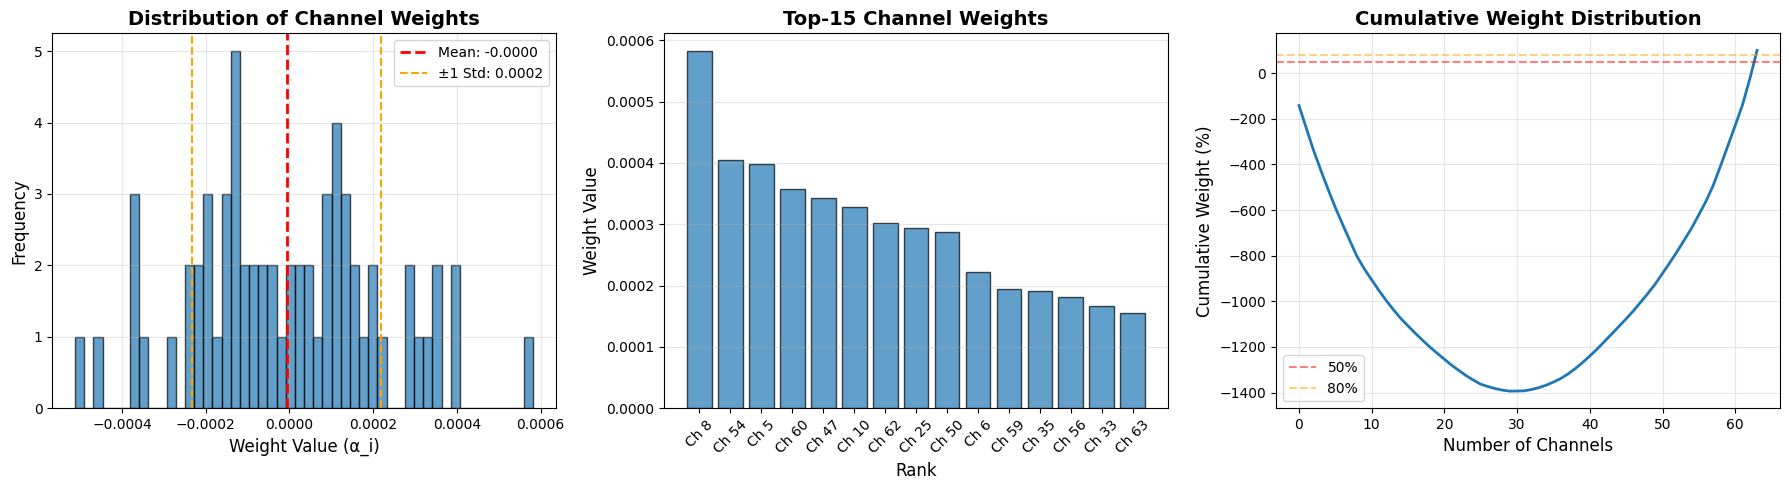


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 64
Mean weight: -0.000006
Std weight: 0.000226
Min weight: -0.000512
Max weight: 0.000582
Weight range: 0.001095

Concentration Analysis:
Top 10% channels (6 channels) contribute: 20.40% of total weight
Top 64 channels contribute 50% of total weight
Top 64 channels contribute 80% of total weight

KL Divergence from uniform: 0.242688
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      8            0.000582        100.00      %
2      54           0.000404        69.39       %
3      5            0.000399        68.47       %
4      60           0.000358        61.51       %
5      47           0.000343        58.99       %
6      10           0.000329        56.43       %
7      62           0.000302        51.81       %
8      25           0.000294        50.46       %
9      50           0.000288 

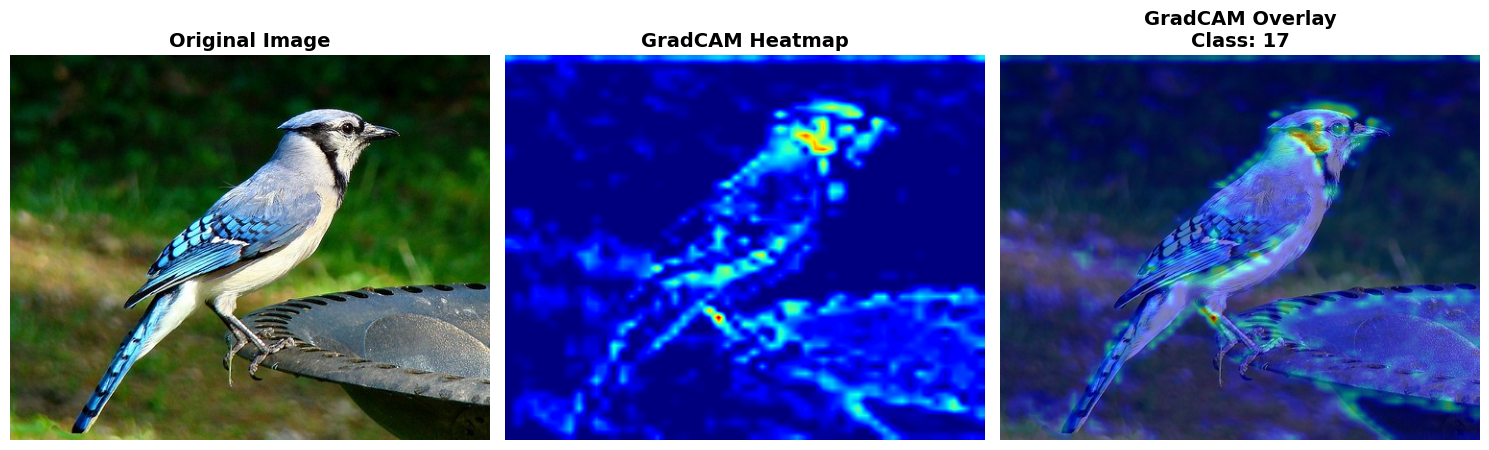

In [26]:
analyze_layer(0)  # Analyze the last conv layer of features

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Predicted class: 17
Number of channels: 192


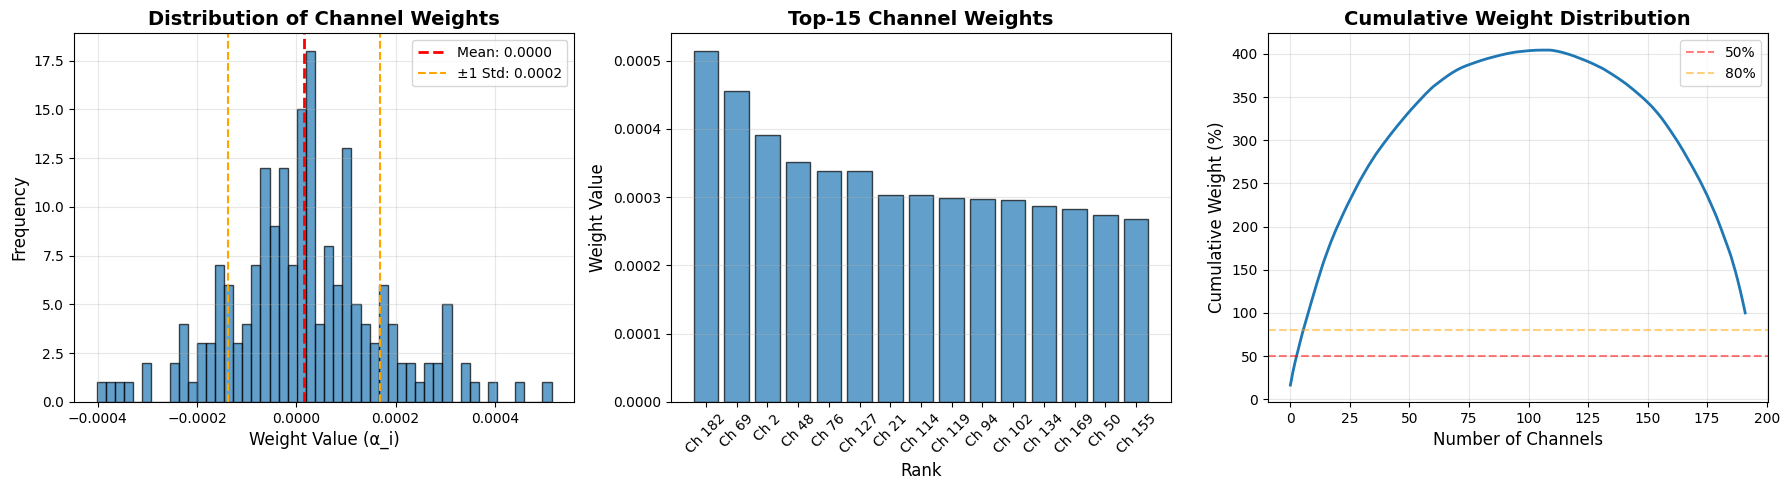


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 192
Mean weight: 0.000016
Std weight: 0.000153
Min weight: -0.000402
Max weight: 0.000514
Weight range: 0.000916

Concentration Analysis:
Top 10% channels (19 channels) contribute: 26.64% of total weight
Top 4 channels contribute 50% of total weight
Top 7 channels contribute 80% of total weight

KL Divergence from uniform: 0.361586
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      182          0.000514        100.00      %
2      69           0.000455        88.43       %
3      2            0.000391        76.13       %
4      48           0.000351        68.27       %
5      76           0.000338        65.83       %
6      127          0.000338        65.82       %
7      21           0.000304        59.07       %
8      114          0.000303        58.93       %
9      119          0.000298  

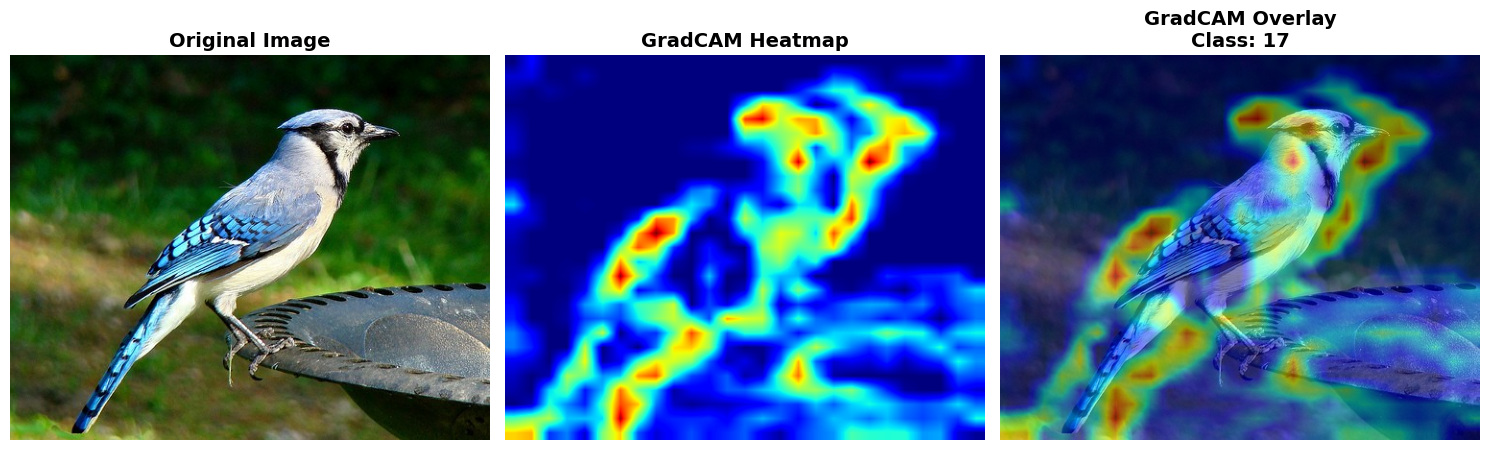

In [27]:
analyze_layer(3)  # Analyze the last conv layer of features

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Predicted class: 17
Number of channels: 384


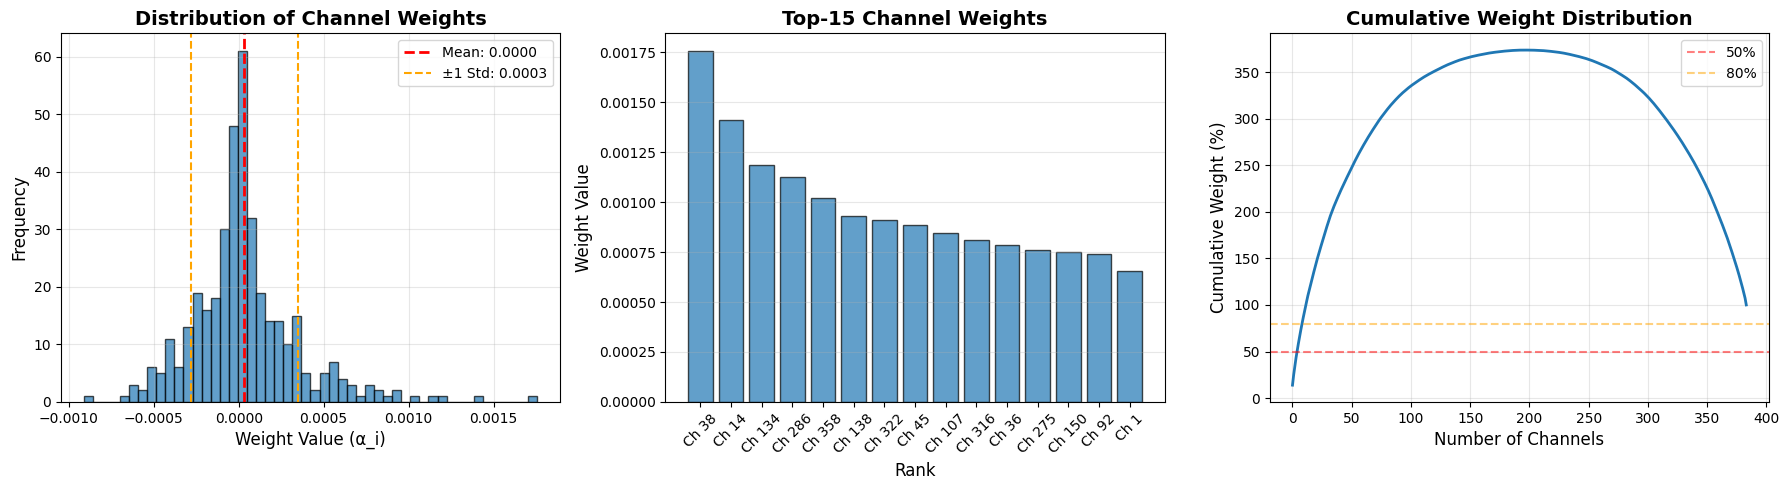


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 384
Mean weight: 0.000033
Std weight: 0.000315
Min weight: -0.000913
Max weight: 0.001758
Weight range: 0.002671

Concentration Analysis:
Top 10% channels (38 channels) contribute: 32.75% of total weight
Top 5 channels contribute 50% of total weight
Top 10 channels contribute 80% of total weight

KL Divergence from uniform: 0.496318
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      38           0.001758        100.00      %
2      14           0.001412        80.31       %
3      134          0.001187        67.52       %
4      286          0.001126        64.05       %
5      358          0.001020        58.03       %
6      138          0.000933        53.08       %
7      322          0.000910        51.79       %
8      45           0.000885        50.36       %
9      107          0.000844 

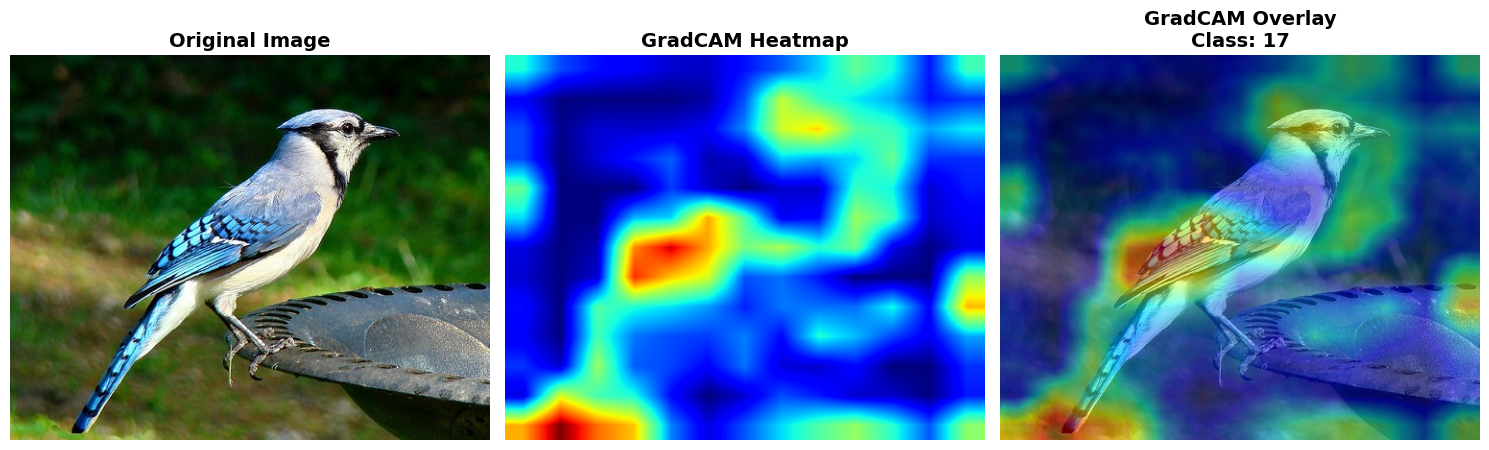

In [28]:
analyze_layer(6)  # Analyze the last conv layer of features

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Predicted class: 17
Number of channels: 256


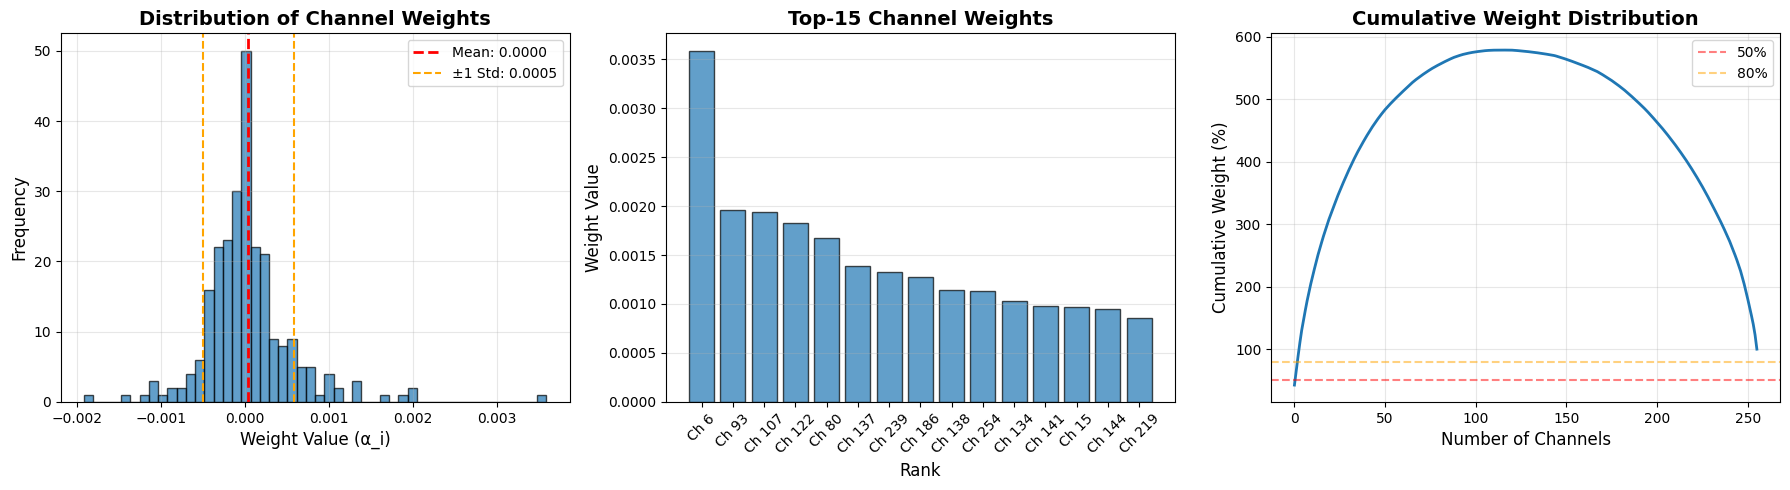


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000033
Std weight: 0.000542
Min weight: -0.001919
Max weight: 0.003586
Weight range: 0.005505

Concentration Analysis:
Top 10% channels (25 channels) contribute: 32.75% of total weight
Top 2 channels contribute 50% of total weight
Top 3 channels contribute 80% of total weight

KL Divergence from uniform: 0.517191
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      6            0.003586        100.00      %
2      93           0.001958        54.60       %
3      107          0.001940        54.09       %
4      122          0.001827        50.94       %
5      80           0.001672        46.64       %
6      137          0.001384        38.59       %
7      239          0.001327        37.01       %
8      186          0.001275        35.56       %
9      138          0.001139  

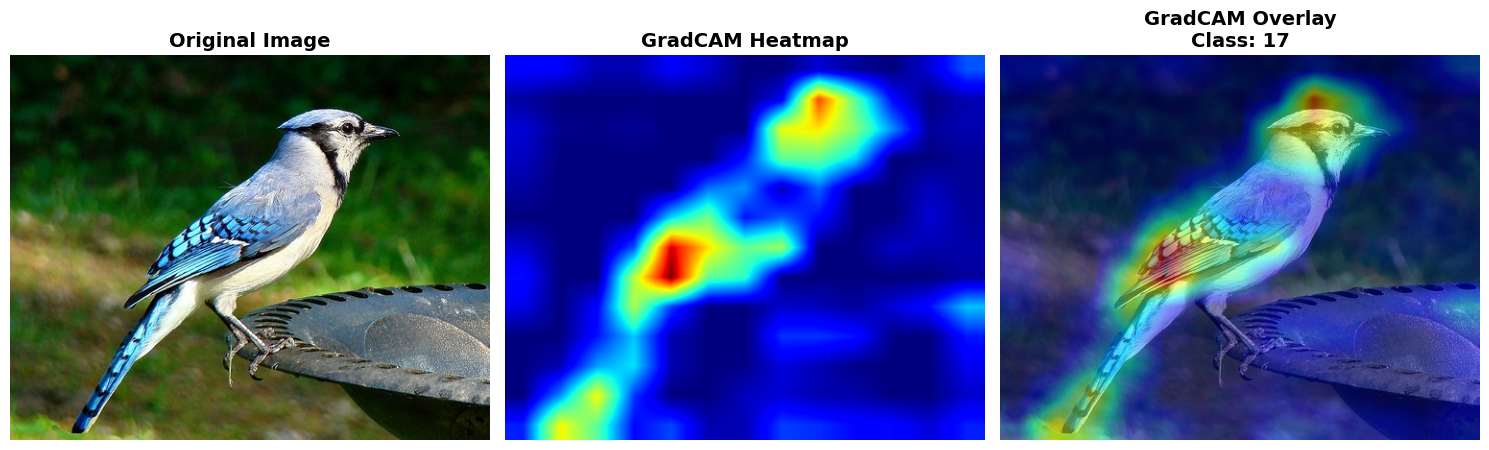

In [29]:
analyze_layer(8)  # Analyze the last conv layer of features

/home/tam/miniconda3/envs/first-env/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Predicted class: 17
Number of channels: 256


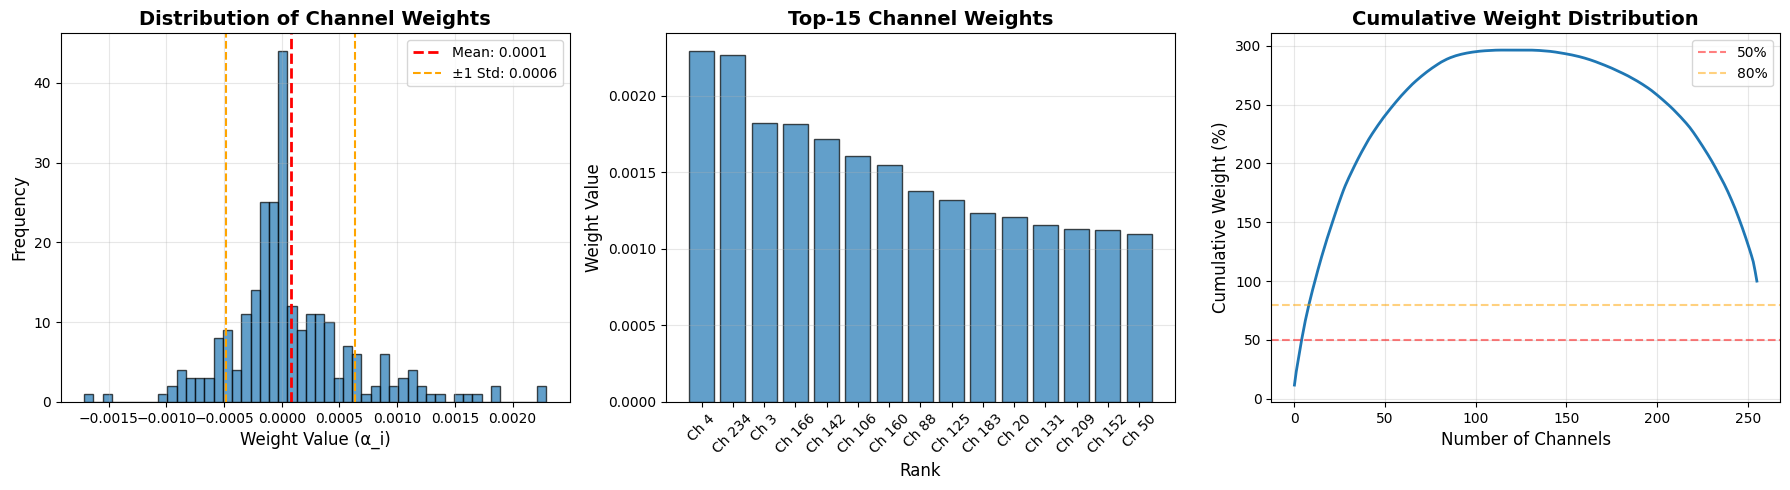


WEIGHT DISTRIBUTION ANALYSIS
Total channels: 256
Mean weight: 0.000077
Std weight: 0.000559
Min weight: -0.001714
Max weight: 0.002294
Weight range: 0.004008

Concentration Analysis:
Top 10% channels (25 channels) contribute: 33.34% of total weight
Top 5 channels contribute 50% of total weight
Top 9 channels contribute 80% of total weight

KL Divergence from uniform: 0.524844
→ Distribution is MODERATELY concentrated

TOP-15 CHANNELS WITH HIGHEST WEIGHTS
Rank   Channel ID   Weight          % of Max    
------------------------------------------------------------
1      4            0.002294        100.00      %
2      234          0.002266        98.77       %
3      3            0.001822        79.44       %
4      166          0.001819        79.28       %
5      142          0.001717        74.84       %
6      106          0.001609        70.13       %
7      160          0.001550        67.56       %
8      88           0.001377        60.03       %
9      125          0.001318  

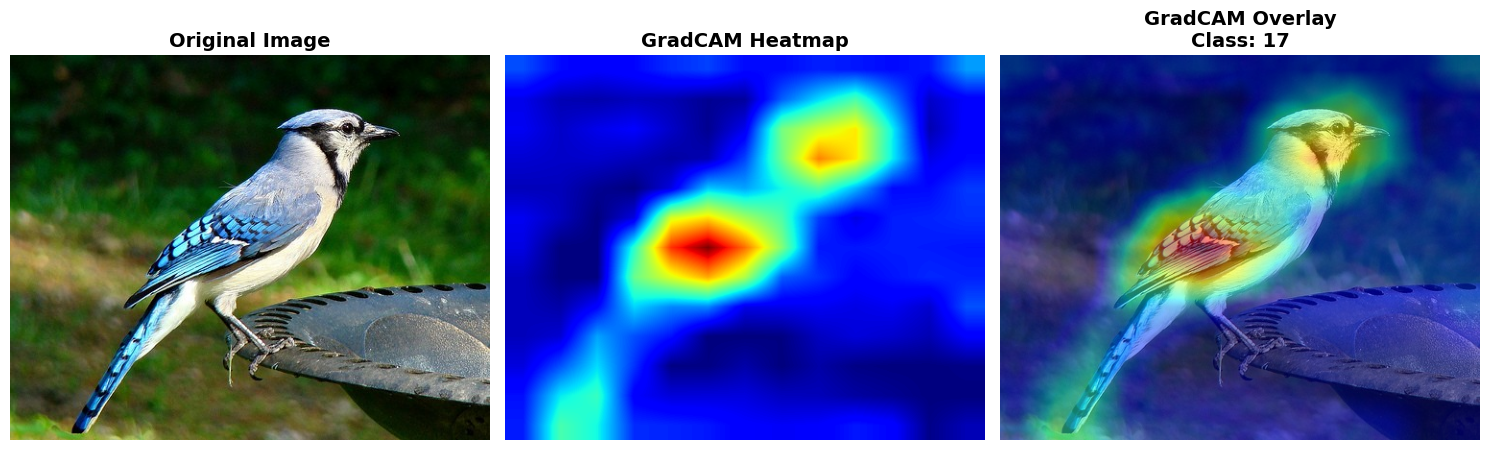

In [30]:
analyze_layer(10)  # Analyze the last conv layer of features